In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import cebra
from cebra import CEBRA
import seaborn as sns
from dataframe.csv_utils import (
    load_data_from_csv,
)

from labels import get_behavioral_labels

from constants import SUEJECT_BATCHES, SORTED_BLOCK_NAMES, V_COLOR_MAP, AUDIO_BLOCKS

## Load data

In [47]:
from data_utils import (
    load_data_from_dir,
)

subject_list = [2033] #, 2017, 2026, 2028, 2033,  2037, 2041
subj_to_data = {}
data_dir = '../CleandDataV2/'
for subj in subject_list:
    dir_name = data_dir + str(subj)
    all_data = load_data_from_dir(dir_name)
    subj_to_data[subj] = all_data

Loading ../CleandDataV2/2033 data...


In [36]:
from features.psd import get_psd_by_channel
from features.time_series import (
    get_block_time_series_features,
)
from labels import get_raw_labels
from feature_extraction import EEG_BANDS, Feature


def get_block_features(blocks, subject_data, marker, channel, feature):
    raw_data = []

    for b in blocks:
        block_data = subject_data[b]
        psd_data = get_psd_by_channel(block_data, marker, channel, feature)
        raw_data = np.vstack((psd_data, raw_data)) if len(raw_data) > 0 else psd_data

    return raw_data


def get_categorical_labels(blocks, subject_data):
    behavioral_labels = []

    for b in blocks:
        block_data = subject_data[b]
        v_label = block_data.get_labels()
        a_label = block_data.get_labels("arousal")

        labels = [
            get_behavioral_labels(v_label[i], a_label[i]) for i in range(len(v_label))
        ]
        behavioral_labels.extend(labels)

    return behavioral_labels


def get_label_means(subject_data):
    v_labels = []
    a_labels = []

    for _, data in subject_data.items():
        v_labels.extend(data.get_labels().flatten())
        a_labels.extend(data.get_labels("arousal").flatten())

    return np.mean(v_labels), np.mean(a_labels)

## Process features

In [48]:
marker = "EEG"
# [2001, 2003, 2017, 2026, 2028, 2033,  2037, 2041]
subj = 2033
subject_data = subj_to_data[subj]

channel_feature_to_data = {"A": {}, "B": {}, "C": {}, "D": {}}
for c in ["A", "B", "C", "D"]:
    for f in EEG_BANDS.keys():
        raw_data = get_block_features(
            AUDIO_BLOCKS, subject_data, marker, c, f
        )
        channel_feature_to_data[c][f] = raw_data

valence_labels, arousal_labels, attention_labels = get_raw_labels(AUDIO_BLOCKS, subject_data)
behavioral_labels = get_categorical_labels(AUDIO_BLOCKS, subject_data)
print(valence_labels)

[0.8, 0.88125, 0.8575, 0.87875, 0.83, 0.84875, 0.91625, 0.7825, 0.6925, 0.81375, 0.87, 0.74, 0.81375, 0.905, 0.8025, 0.93, 0.9025, 0.87125, 0.88625, 0.91375, 0.86125, 0.89875, 0.88125, 0.9375, 0.88, 0.75625, 0.49625, 0.51875, 0.5, 0.5, 0.5, 0.51, 0.5, 0.5, 0.5, 0.5, 0.45875, 0.54875, 0.5, 0.4475, 0.7375, 0.8225, 0.615, 0.79625, 0.7125, 0.69375, 0.72125, 0.53625, 0.7175, 0.67625, 0.755, 0.7425]


In [ ]:
def subplot_confusion_matrix(cf,
                          ax=None,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent='all',
                          cbar=True,
                          cbar_ax=None,
                          xyticks=True,
                          vmin=0, vmax=3000,
                          cmap='Blues'):

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent == 'all':
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    elif percent == 'by_row':
        group_percentages = []
        cf_matrix = []
        for cfg in cf:
            values = ["{0:.2%}".format(value) for value in cfg/np.sum(cfg)]
            group_percentages.extend(values)
            cf_matrix.append([float("{0:.2}".format(value)) for value in cfg/np.sum(cfg)])
        
        cf = np.array(cf_matrix)
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    return sns.heatmap(
      cf,
      annot=box_labels,
      fmt="",
      cmap=cmap,
      cbar=cbar,
      cbar_ax=cbar_ax,
      vmin=vmin, vmax=vmax,
      xticklabels=categories,
      yticklabels=categories, 
      ax=ax)

## Model Training

In [42]:
import ipywidgets as widgets
from sklearn.decomposition import PCA 

IDX_MAP = {
    "hvha": 0,
    "hvla": 1,
    "nvha": 2,
    "nvla": 3,
    "lvha": "blue",
    "lvla": "steelblue",
}


def upsample_by_attention(attention, num_output):
    from sklearn.preprocessing import MinMaxScaler
    import random

    scaler = MinMaxScaler(feature_range=(0, 100))
    weights = scaler.fit_transform(attention.reshape(-1, 1))

    random.seed(33)
    resampled_features = random.choices(
        np.arange(0, len(attention), 1), weights=weights, k=num_output
    )

    return np.array(resampled_features)


def model_fit(
    neural_data,
    out_dim,
    num_hidden_units,
    behavioral_labels,
    max_iterations: int = 10,
    max_adapt_iterations: int = 10,
):
    single_cebra_model = CEBRA(
        # model_architecture = "offset10-model",
        batch_size=512,
        output_dimension=out_dim,
        max_iterations=max_iterations,
        num_hidden_units=num_hidden_units,
        max_adapt_iterations=max_adapt_iterations,
    )

    if behavioral_labels is None:
        single_cebra_model.fit(neural_data)
    else:
        single_cebra_model.fit(neural_data, behavioral_labels)
    # cebra.plot_loss(single_cebra_model)
    return single_cebra_model


def get_embeddings(
    train_data,
    val_data,
    train_labels,
    use_pca: bool = False,
    out_dim: int = 16,
    num_hidden_units: int = 256,
):
    if use_pca:
        # Run PCA
        pca = PCA(n_components=2)
        pca = pca.fit(train_data)
        return pca.transform(train_data), pca.transform(val_data)

    single_cebra_model = model_fit(train_data, out_dim, num_hidden_units, train_labels)

    # Calculate embedding
    embedding = single_cebra_model.transform(train_data)
    val_embedding = single_cebra_model.transform(val_data)
    return embedding, val_embedding


label_selector = widgets.Dropdown(
    options=["valence", "hybrid", "arousal"],
    value="valence",
    description="label_type:",
    disabled=False,
)
label_selector

Dropdown(description='label_type:', options=('valence', 'hybrid', 'arousal'), value='valence')

In [57]:
def get_label_category(labels, label_type, v_thred, a_thred):
    threshold = a_thred if label_type == "arousal" else v_thred
    return [0 if p < threshold else 1 for p in labels]

label_type = label_selector.value

if label_type == "valence":
    labels = valence_labels
elif label_type == "arousal":
    labels = arousal_labels
else:
    labels = [IDX_MAP[l] for l in behavioral_labels]

loss_data = {"A": {}, "B": {}, "C": {}, "D": {}}
r2_score_data = {"A": {}, "B": {}, "C": {}, "D": {}}

output_dim = 8
max_hidden_units = 256

0.750778846153846 0.44479807692307693


### Cross Validation

In [ ]:
val_sz = 5
def get_resampled_list_index(val_index, attention_labels):
    # exclude validation 
    train_attention_labels = np.array(attention_labels[:val_index] + attention_labels[val_index+val_sz:])
    # up sample by attention labels
    resampled_list = upsample_by_attention(train_attention_labels, len(train_attention_labels) * 4)
    return resampled_list

def _train_test_split(data, labels, resampled_list, val_index):
    train_labels = labels[:val_index] + labels[val_index+val_sz:]

    train_labels = np.array(train_labels)[resampled_list]
    train_data = np.vstack([data[:val_index],data[val_index+val_sz:]])
    train_data = np.array(train_data)[resampled_list]

    val_data = data[val_index:val_index+val_sz]
    val_label = labels[val_index:val_index+val_sz]
    return train_data, train_labels, val_data, val_label

for channel, feature_to_data in channel_feature_to_data.items():
    if len(feature_to_data) == 0:
        continue

    for f, neural_data in feature_to_data.items():
        for val_index in range(0, len(labels)-val_sz, val_sz):
             # Prepare the data
            resampled_list = get_resampled_list_index(val_index, attention_labels)
            train_data, train_labels, val_data, val_labels = _train_test_split(neural_data, labels, resampled_list, val_index) 

            embedding, val_embedding = get_embeddings(
                train_data=train_data,
                val_data=val_data,
                train_labels=train_labels,
                use_pca=use_pca,
                out_dim=output_dim,
                num_hidden_units=max_hidden_units,
            )

            # 4. Train the decoder on training embedding and labels
            train_true_cat = get_label_category(train_labels, label_type)
            val_true_cat =  get_label_category(val_labels, label_type)
            decoder = cebra.KNNDecoder()
            decoder.fit(embedding, np.array(train_true_cat))

            # 5. Compute the score on validation embedding and labels
            score = decoder.score(val_embedding, np.array(val_true_cat))
            r2_score_data[channel][f.name] = r2_score_data[channel][f.name] + score if f.name in r2_score_data[channel] else score

            #prediction = decoder.predict(val_embedding)
            # print('pre', prediction)
            # print('true', val_true_cat)
            # print('--------')
        print(channel, f, r2_score_data[channel][f.name])

In [ ]:
mdf = pd.melt(pd.DataFrame(r2_score_data), id_vars=[], value_vars=['A', 'B', 'C', 'D'])
names = [ i.name for i in EEG_BANDS.keys()]
mdf['band'] = names*4
sns.barplot(x = 'variable', y = 'value' , data = mdf, hue = 'band' )

### Leave last two trials in each block as validation

0.750778846153846 0.44479807692307693
A Feature.DELTA -0.8749999999999998
A Feature.THETA -1.6249999999999996
A Feature.ALPHA -2.3749999999999996
A Feature.BETA1 -1.2499999999999996
A Feature.BETA2 -1.9999999999999996
A Feature.GAMMA -1.6249999999999996
B Feature.DELTA -1.6249999999999996
B Feature.THETA -1.9999999999999996
B Feature.ALPHA -0.8749999999999998
B Feature.BETA1 -0.4999999999999998
B Feature.BETA2 -1.6249999999999996
B Feature.GAMMA -0.8749999999999998
C Feature.DELTA -0.12499999999999978
C Feature.THETA -0.4999999999999998
C Feature.ALPHA -0.8749999999999998
C Feature.BETA1 -0.12499999999999978
C Feature.BETA2 -0.12499999999999978
C Feature.GAMMA 0.2500000000000001
D Feature.DELTA -0.12499999999999978
D Feature.THETA -0.8749999999999998
D Feature.ALPHA -1.6249999999999996
D Feature.BETA1 -1.6249999999999996
D Feature.BETA2 -0.8749999999999998
D Feature.GAMMA -1.2499999999999996


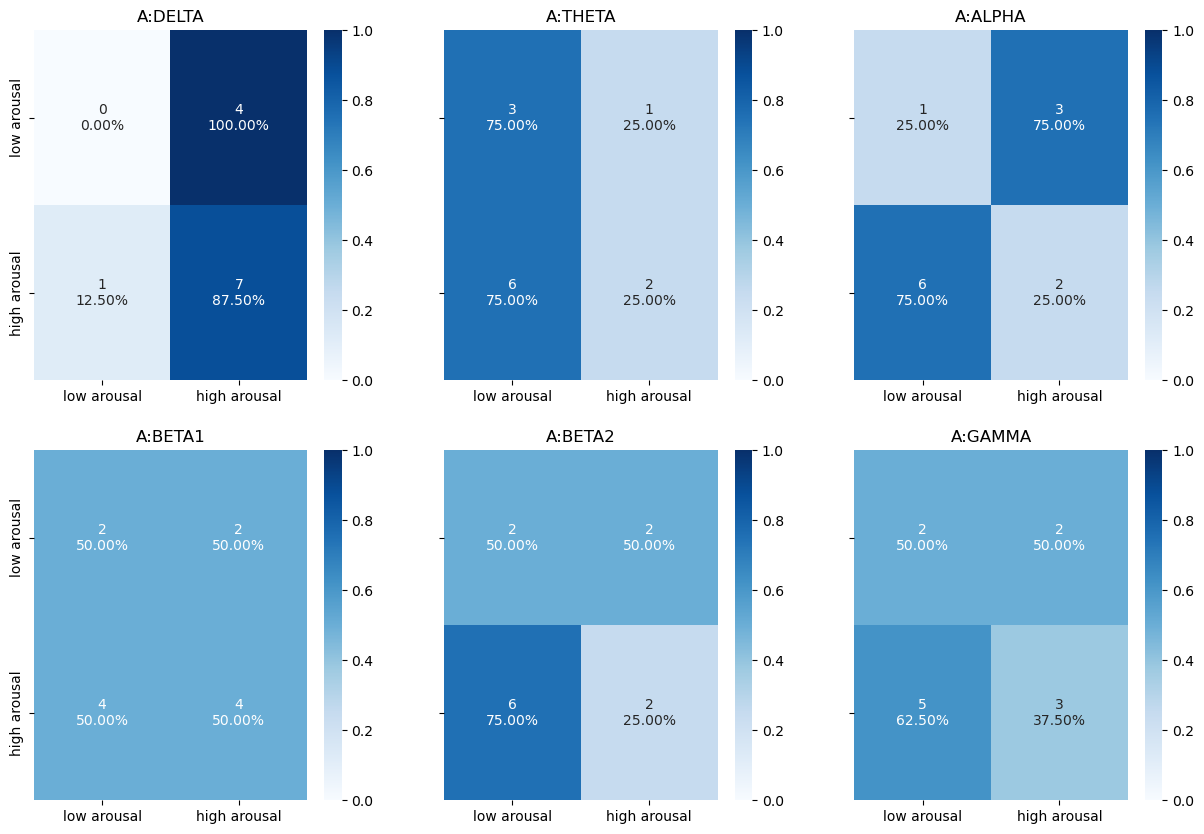

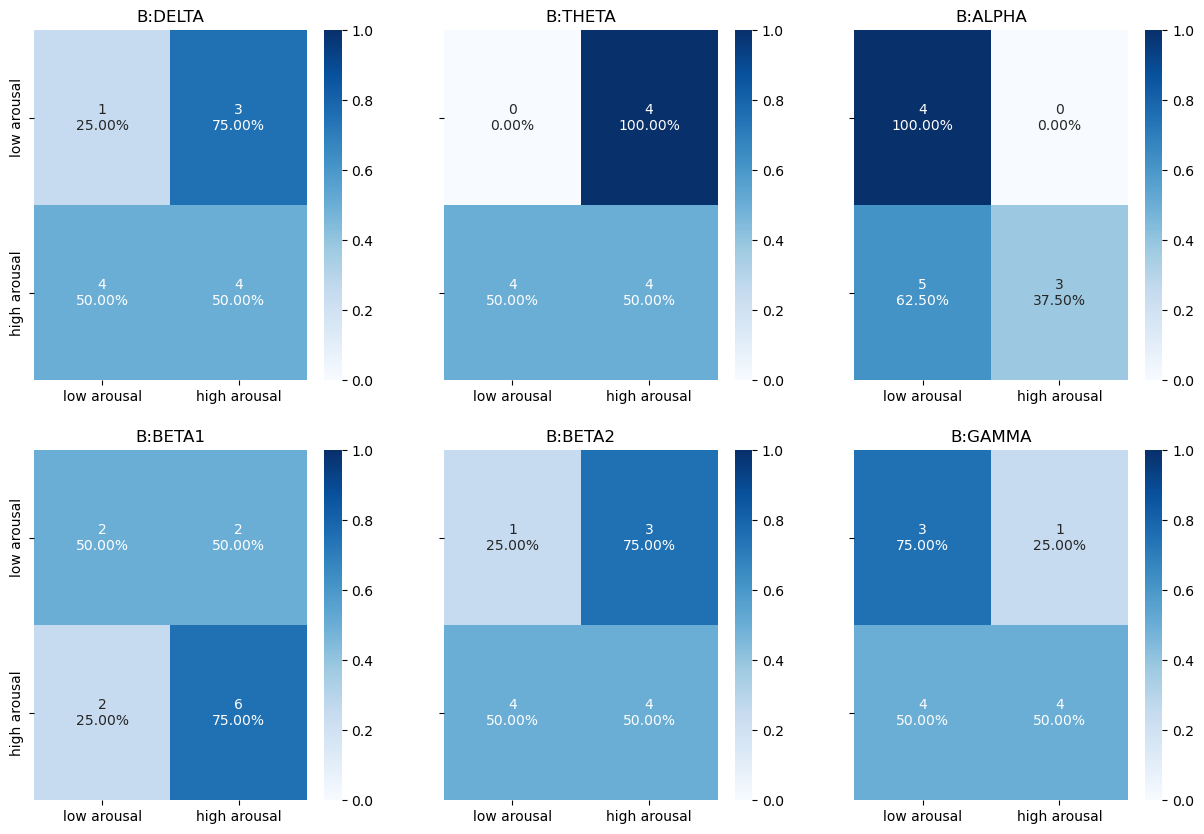

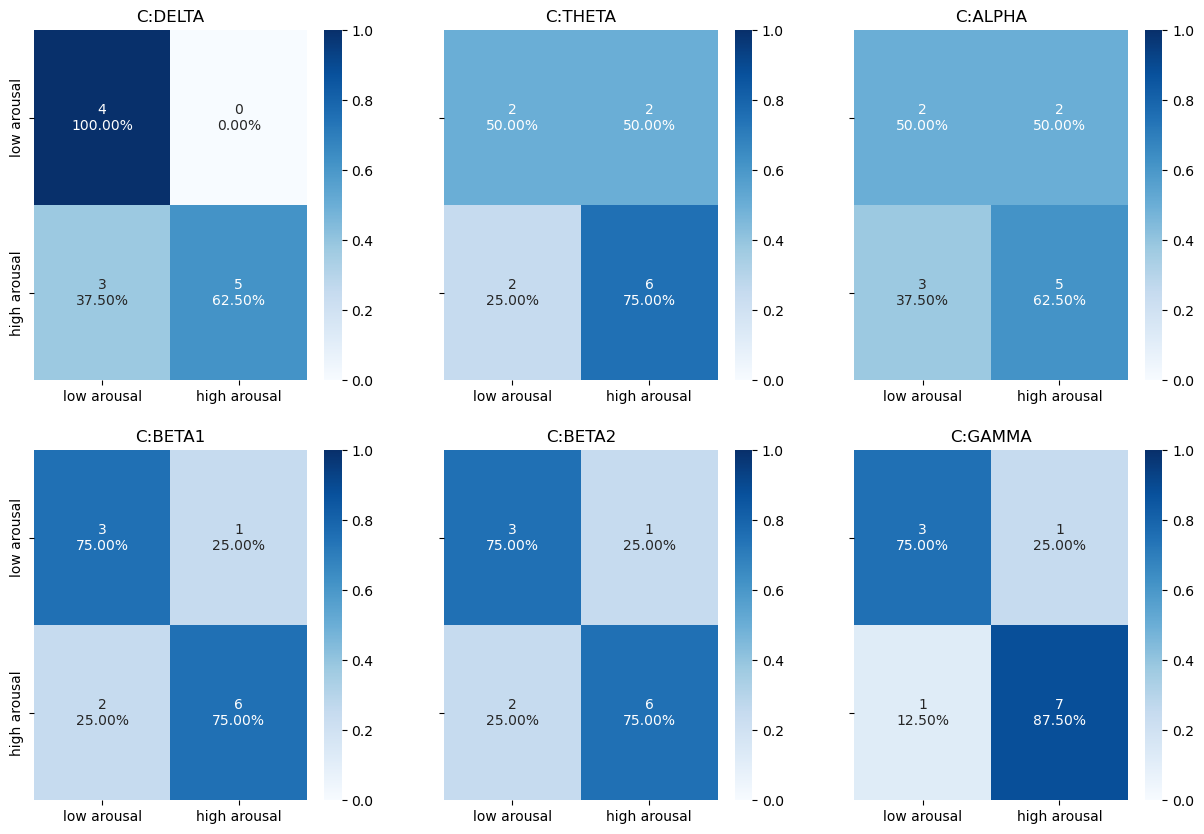

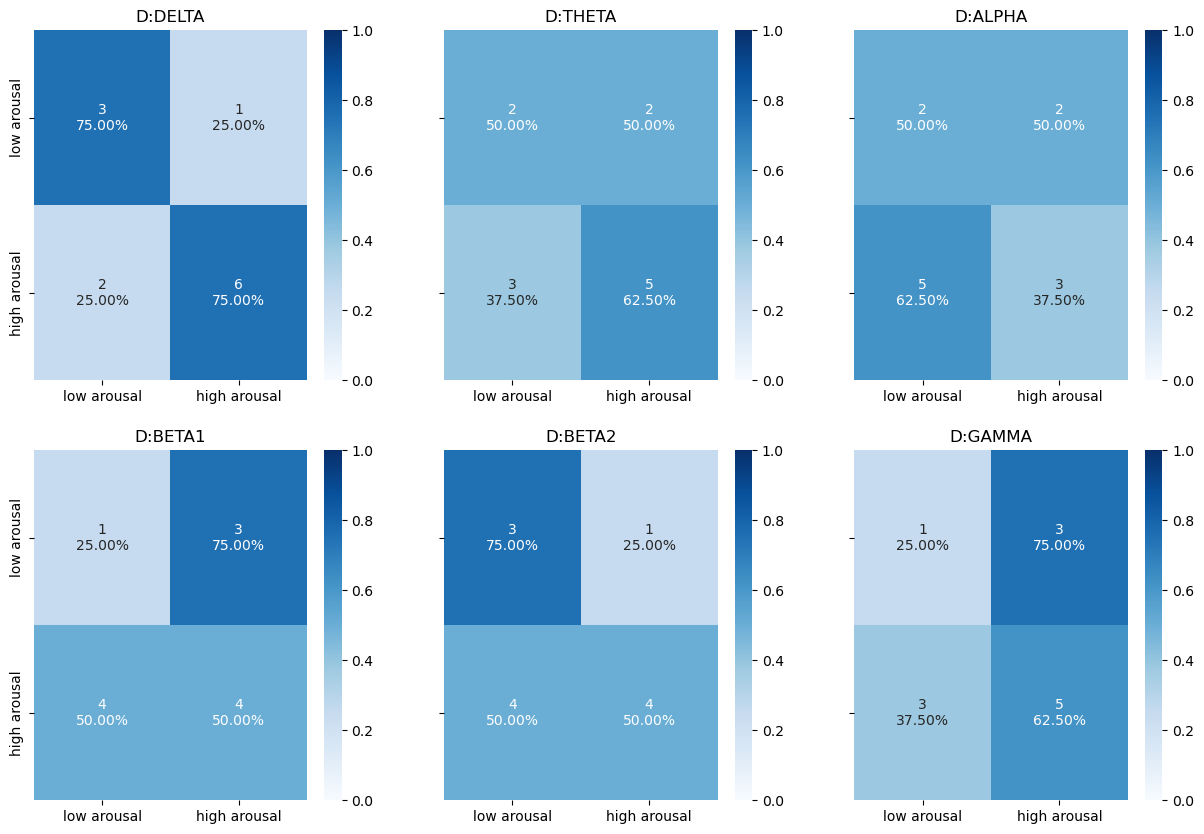

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

use_pca = True
use_subject_mean = True

v_thred, a_thred = get_label_means(subject_data) if use_subject_mean else (0.6, 0.5)
print(v_thred, a_thred)

validation_list = [10, 11, 12, 23, 24, 25, 36, 37, 38, 49, 50, 51]
train_list = [i for i in range(len(valence_labels)) if i not in validation_list]

train_attention_labels = np.array(attention_labels)[train_list]
resampled_list = upsample_by_attention(train_attention_labels, 52 * 4)
train_labels = np.array(labels)[train_list][resampled_list]

validation_labels = np.array(labels)[validation_list]

train_true_cat = get_label_category(train_labels, label_type, v_thred, a_thred)
val_true_cat = get_label_category(validation_labels, label_type, v_thred, a_thred)

for channel, feature_to_data in channel_feature_to_data.items():
    if len(feature_to_data) == 0:
        continue

    nrows = 2
    ncols = int(len(feature_to_data) / 2)
    fig, axes = plt.subplots(
        nrows=nrows,
        sharey=True,
        ncols=ncols,
        figsize=(ncols * 5, nrows * 5),
    )

    idx = 0
    for f, neural_data in feature_to_data.items():
        train_data = neural_data[train_list][resampled_list]
        val_data = neural_data[validation_list]

        # loss_data[channel][f.name] = single_cebra_model.state_dict_["loss"]
        embedding, val_embedding = get_embeddings(
            train_data=train_data,
            val_data=val_data,
            train_labels=train_labels,
            use_pca=use_pca,
            out_dim=output_dim,
            num_hidden_units=max_hidden_units,
        )
        # 4. Train the decoder on training embedding and labels
        decoder = cebra.KNNDecoder()
        decoder.fit(embedding, np.array(train_true_cat))

        # 5. Compute the score on validation embedding and labels
        score = decoder.score(val_embedding, np.array(val_true_cat))
        r2_score_data[channel][f.name] = score
        # 5. Get the discrete labels predictions
        prediction = decoder.predict(val_embedding)
        print(channel, f, score)
        # print('pre', prediction)
        # print('true', val_true_cat)
        # print('--------')
        cm = confusion_matrix(val_true_cat, prediction)
        subplot_confusion_matrix(
            ax=axes.flat[idx],
            cf=cm,
            categories=[f"low {label_type}", f"high {label_type}"],
            percent="by_row",
            vmin=0,
            vmax=1,
        )
        # disp = ConfusionMatrixDisplay(
        #     confusion_matrix=cm,
        #     display_labels=[f"neutral {label_type}", f"high {label_type}"],
        # )
        # disp.plot(ax=axes.flat[idx])
        axes.flat[idx].set_title(f"{channel}:{f.name}")
        idx += 1

In [ ]:
nrows = 1
ncols = len(loss_data)
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
     sharey=True,
    figsize=(ncols * 5, nrows * 5),
)

fig.suptitle(
    f"Subject {subj}: {marker} {label_type} InfoNCE loss in audio condition",
    fontsize=15,
)
       
for c, ax in zip(loss_data.keys(), axes.flatten()):
    df = pd.DataFrame(loss_data[c])
    sns.lineplot(data=df, ax=ax)
    ax.set_title('channel:' + c)
    ax.set_ylabel('InfoNCE Loss')
    ax.set_xlabel('Steps')
#plt.savefig(f"results/cebra/{label_type}_{subj}_eeg_bands_channel_loss_{channel}_O{output_dim}H{max_hidden_units}.png")

In [ ]:
loss_dict = {'InfoNCE Loss': [], 'band': [], 'channel': [], 'Steps': []}
for c , f_to_data in loss_data.items():
    for f, data in f_to_data.items():
        loss_dict['InfoNCE Loss'].extend(np.array(data))
        loss_dict['Steps'].extend(np.arange(0, len(data), dtype=int))
        loss_dict['band'].extend([f]*len(data))
        loss_dict['channel'].extend([c]*len(data))

loss_dict = pd.DataFrame(loss_dict)
loss_dict

In [ ]:
sns.lineplot(data=loss_dict, y='InfoNCE Loss', x='Steps', hue='band', style='channel')

In [ ]:
# 1. Define the parameters, either variable or fixed
params_grid = dict(
    output_dimension=[6, 8],
    learning_rate=[3e-4],
    max_iterations=10,
    num_hidden_units=[32, 64, 128, 256],
    max_adapt_iterations=10,
    temperature_mode="auto",
    verbose=False,
)

# 2. Define the datasets to iterate over
datasets = {
    "neural_data": channel_feature_to_data["C"][Feature.THETA],
}

# 3. Create and fit the grid search to your data
grid_search = cebra.grid_search.GridSearch()
grid_search = grid_search.fit_models(datasets=datasets, params=params_grid, models_dir="saved_models")

# 4. Get the results
df_results = grid_search.get_df_results(models_dir="saved_models")
# 5. Get the best model for a given dataset
best_model, best_model_name = grid_search.get_best_model(dataset_name="neural_data", models_dir="saved_models")

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")

ax1 = cebra.plot_embedding(embedding, embedding_labels=np.array(cmap), idx_order=(1,2,3), title="Latents: (1,2,3)", ax=ax1, markersize=5, alpha=0.6)
ax2 = cebra.plot_embedding(embedding, embedding_labels=np.array(cmap), idx_order=(4,5,6), title="Latents: (4,5,6)", ax=ax2, markersize=5, alpha=0.6)